In [4]:
import os
import json
import pandas as pd
from google.colab import drive
import numpy as np
drive.mount('/content/drive')
root_dir = '/content/drive/MyDrive/ITAM_DATA'

Mounted at /content/drive


In [ ]:
# Duyệt qua các thư mục con trong ITAM_DATA
data_list = []
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        # Tìm file performance.json trong thư mục con
        performance_file = os.path.join(subdir_path, 'performance.json')
        if os.path.exists(performance_file):
            with open(performance_file, 'r') as f:
                data = json.load(f)
                # Iterate through each element in the list
                for item in data:  # Now, 'item' will be each dictionary within the list
                    # Trích xuất các trường dữ liệu cần thiết
                    extracted_data = {
                        'cpu_utilization': item.get('cpu', {}).get('utilization', np.nan),
                        'cpu_processes':item.get('cpu', {}).get('processes', np.nan),
                        'cpu_uptime':item.get('cpu',{}).get('uptime', np.nan),
                        'ram_percent': item.get('ram', {}).get('percent', np.nan),
                        'inet_card_speed': item.get('network', {}).get('inet_card_speed', np.nan),
                        'total_memory_used': item.get('physical_disks', {}).get('total_memory_used', np.nan),
                        'percent_mem_used': item.get('physical_disks', {}).get('percent_mem_used', np.nan),
                        'boot_time': item.get('boot_time', np.nan),
                        'scantime': item.get('scantime', np.nan),
                        'location': item.get('location', np.nan),
                        'currentUser': item.get('currentUser', np.nan),
                    }
                    data_list.append(extracted_data)

# Tạo DataFrame từ danh sách dữ liệu
df = pd.DataFrame(data_list)

# Lưu thành file CSV
df.to_csv('/content/drive/MyDrive/ITAM_DATA/performance_data.csv', index=False)
print("Đã lưu file CSV thành công!")

##Tiền xử lý dữ liệu

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [8]:
drive.mount('/content/drive')
root_dir = '/content/drive/MyDrive/ITAM_DATA'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df = pd.read_csv('/content/drive/MyDrive/ITAM_DATA/performance_data.csv')
df_info= df.info()
df_head= df.head()
df_info,df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1927 entries, 0 to 1926
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cpu_utilization    1927 non-null   float64
 1   cpu_processes      1927 non-null   int64  
 2   cpu_uptime         1927 non-null   object 
 3   ram_percent        1927 non-null   float64
 4   inet_card_speed    1927 non-null   int64  
 5   total_memory_used  1927 non-null   float64
 6   percent_mem_used   1927 non-null   float64
 7   boot_time          1927 non-null   object 
 8   scantime           1865 non-null   object 
 9   location           1927 non-null   object 
 10  currentUser        1927 non-null   object 
dtypes: float64(4), int64(2), object(5)
memory usage: 165.7+ KB


(None,
    cpu_utilization  cpu_processes  cpu_uptime  ram_percent  inet_card_speed  \
 0           9.0750            195  0:00:00:45         51.2              390   
 1          20.8750            225  0:00:10:48         84.6              390   
 2          30.7875            217  0:00:20:52         80.0              390   
 3          40.8750            222  0:00:30:56         78.9              370   
 4          11.3500            212  0:00:41:01         56.1              390   
 
    total_memory_used  percent_mem_used            boot_time scantime location  \
 0             386.10             84.32  2025-04-13 21:10:29      NaN   LOC003   
 1             386.11             84.32  2025-04-13 21:10:29      NaN   LOC003   
 2             386.12             84.32  2025-04-13 21:10:29      NaN   LOC003   
 3             386.12             84.32  2025-04-13 21:10:29      NaN   LOC003   
 4             386.12             84.32  2025-04-13 21:10:29      NaN   LOC003   
 
   currentUser  


In [10]:
# Hàm chuyển đổi uptime sang timedelta
from datetime import datetime, timedelta
def uptime_to_timedelta(uptime_str):
    days, hours, minutes, seconds = map(int, uptime_str.split(':'))
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
df['boot_time'] = pd.to_datetime(df['boot_time'])
df['uptime_td'] = df['cpu_uptime'].apply(uptime_to_timedelta)
df['scantime'] = pd.to_datetime(df['scantime'], errors='coerce')
mask = df['scantime'].isna()
df.loc[mask, 'scantime'] = df.loc[mask, 'boot_time'] + df.loc[mask, 'uptime_td']
df = df.drop(columns=['uptime_td'])
df.head()

,cpu_utilization,cpu_processes,cpu_uptime,ram_percent,inet_card_speed,total_memory_used,percent_mem_used,boot_time,scantime,location,currentUser
0,9.0750,195,0:00:00:45,51.2,390,386.10,84.32,2025-04-13 21:10:29,2025-04-13 21:11:14,LOC003,hansle
1,20.8750,225,0:00:10:48,84.6,390,386.11,84.32,2025-04-13 21:10:29,2025-04-13 21:21:17,LOC003,hansle
2,30.7875,217,0:00:20:52,80.0,390,386.12,84.32,2025-04-13 21:10:29,2025-04-13 21:31:21,LOC003,hansle
3,40.8750,222,0:00:30:56,78.9,370,386.12,84.32,2025-04-13 21:10:29,2025-04-13 21:41:25,LOC003,hansle
4,11.3500,212,0:00:41:01,56.1,390,386.12,84.32,2025-04-13 21:10:29,2025-04-13 21:51:30,LOC003,hansle


In [23]:
df['cpu_processes'] = df['cpu_processes'].astype(int)
df['cpu_utilization'] = df['cpu_utilization'].astype(float)
df['ram_percent'] = df['ram_percent'].astype(float)
df['hour'] = df['scantime'].dt.hour
df['is_working_hour'] = df['hour'].between(8, 18).astype(int)
df['is_weekday'] = (df['scantime'].dt.weekday < 5).astype(int)
df.head(5)

,cpu_utilization,cpu_processes,ram_percent,scantime,currentUser,is_working_hour,is_weekday,hour
337,94.4625,182,34.1,2025-04-14 18:59:12.857862,DESKTOP-6LS3N6H,1,1,18
338,3.9250,224,45.0,2025-04-14 18:59:50.707623,DESKTOP-6LS3N6H,1,1,18
339,19.7125,257,54.7,2025-04-14 19:09:16.160324,DESKTOP-6LS3N6H,0,1,19
340,20.2250,259,54.9,2025-04-14 19:09:54.192586,DESKTOP-6LS3N6H,0,1,19
341,19.1000,255,52.1,2025-04-14 19:19:19.517229,DESKTOP-6LS3N6H,0,1,19


In [24]:
#print num of is_working hour records
print(df['is_working_hour'].sum())
#print num of non working hour records
print(len(df) - df['is_working_hour'].sum())

970
957


In [25]:
df = df[['cpu_utilization','cpu_processes', 'ram_percent','scantime','currentUser','is_working_hour','is_weekday','hour']]
df.head()


,cpu_utilization,cpu_processes,ram_percent,scantime,currentUser,is_working_hour,is_weekday,hour
337,94.4625,182,34.1,2025-04-14 18:59:12.857862,DESKTOP-6LS3N6H,1,1,18
338,3.9250,224,45.0,2025-04-14 18:59:50.707623,DESKTOP-6LS3N6H,1,1,18
339,19.7125,257,54.7,2025-04-14 19:09:16.160324,DESKTOP-6LS3N6H,0,1,19
340,20.2250,259,54.9,2025-04-14 19:09:54.192586,DESKTOP-6LS3N6H,0,1,19
341,19.1000,255,52.1,2025-04-14 19:19:19.517229,DESKTOP-6LS3N6H,0,1,19


In [26]:
# Đảm bảo sắp xếp đúng trước khi phân đoạn
df.sort_values(by=['currentUser', 'scantime'], inplace=True)

In [27]:
def split_sequences_by_gap(df_user, gap_minutes=20, min_segment_length=4):
    df_user = df_user.sort_values('scantime').copy()
    df_user['time_diff'] = df_user['scantime'].diff().dt.total_seconds().fillna(0) / 60

    segments = []
    start_idx = 0
    for i in range(1, len(df_user)):
        if df_user.iloc[i]['time_diff'] > gap_minutes:
            segment = df_user.iloc[start_idx:i].copy()
            if len(segment) >= min_segment_length:
                segments.append(segment)
            start_idx = i
    # Add the last segment
    segment = df_user.iloc[start_idx:].copy()
    if len(segment) >= min_segment_length:
        segments.append(segment)
    return segments

In [33]:
user_segments = []

for user_id, group in df.groupby('currentUser'):
    segments = split_sequences_by_gap(group, gap_minutes=20)
    for seg in segments:
        seg = seg.sort_values('scantime').copy()
        seg['currentUser'] = user_id

        # Tính delta
        seg['delta_cpu'] = seg['cpu_utilization'].diff().fillna(0)
        seg['delta_ram'] = seg['ram_percent'].diff().fillna(0)
        seg['delta_processes'] = seg['cpu_processes'].diff().fillna(0).astype(int)

        # Thêm cột is_after_boot
        seg['is_after_boot'] = 0
        seg.iloc[0, seg.columns.get_loc('is_after_boot')] = 1

        user_segments.append(seg)

In [151]:
# Lấy một đoạn đầu tiên
sample_segment = user_segments[25]
print(len(user_segments))
# Hiển thị vài dòng đầu
print(sample_segment[['cpu_processes','currentUser', 'scantime', 'cpu_utilization', 'ram_percent','is_working_hour','delta_cpu','delta_ram','is_weekday','is_after_boot','hour','delta_processes']].head(10))

72
     cpu_processes currentUser                   scantime  cpu_utilization  \
660            267    duong_03 2025-04-18 08:59:26.903520        91.125000   
661            257    duong_03 2025-04-18 09:09:30.494794         3.750000   
662            269    duong_03 2025-04-18 09:22:47.326626        71.441667   
663            262    duong_03 2025-04-18 09:32:50.921694         8.650000   
664            264    duong_03 2025-04-18 09:42:54.444507         3.250000   
665            259    duong_03 2025-04-18 09:52:57.915268        14.591667   
666            265    duong_03 2025-04-18 10:03:01.466579         2.700000   
667            260    duong_03 2025-04-18 10:13:05.069225         1.700000   
668            261    duong_03 2025-04-18 10:23:08.618788         8.116667   
669            258    duong_03 2025-04-18 10:33:12.164785         5.991667   

     ram_percent  is_working_hour  delta_cpu  delta_ram  is_weekday  \
660         61.4                1   0.000000        0.0           1

In [45]:
# Tìm segment có độ dài nhỏ nhất
min_segment = min(user_segments, key=len)

# In độ dài và nội dung
print("Độ dài nhỏ nhất:", len(min_segment))

Độ dài nhỏ nhất: 4


In [44]:
#Tìm seg có độ dài lớn nhất
max_segment = max(user_segments, key=len)

# In độ dài và nội dung
print("Độ dài lớn nhất:", len(max_segment))

Độ dài lớn nhất: 82


In [ ]:
#In số lượng seg có độ dài nhỏ hơn 6
count = sum(1 for seg in user_segments if len(seg) < 6)
print("Số lượng segment có độ dài nhỏ hơn 6:", count)
#In số lượng seg có độ dài lớn hơn 12
count = sum(1 for seg in user_segments if len(seg) > 8)
print("Số lượng segment có độ dài lớn hơn 12:", count)

In [118]:
def create_sequences(df, target_col, feature_cols, n_steps=12):
    """
    Tạo chuỗi time series đầu vào và đầu ra.

    Args:
        df (pd.DataFrame): Dữ liệu đã sắp xếp theo thời gian.
        target_col (str): Cột mục tiêu để dự đoán ('cpu.utilization' hoặc 'ram.percent').
        feature_cols (list): Danh sách các cột đặc trưng đầu vào.
        n_steps (int): Số bước thời gian.

    Returns:
        X (np.array): (samples, n_steps, num_features)
        y (np.array): (samples, 1)
    """
    X, y = [], []
    df = df.sort_values('scantime')

    if len(df) <= n_steps:
        return np.empty((0, n_steps, len(feature_cols))), np.empty((0, 1))

    for i in range(len(df) - n_steps):
        seq_x = df.iloc[i:i+n_steps][feature_cols].values
        seq_y = df.iloc[i+n_steps][target_col]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y).reshape(-1, 1)

# Danh sách đặc trưng cho từng mô hình
features_cpu = ['cpu_utilization', 'cpu_processes', 'is_working_hour','ram_percent','hour','delta_processes','delta_cpu','is_after_boot','is_weekday']
features_ram = ['ram_percent', 'is_working_hour','is_weekday','is_after_boot','delta_ram','delta_cpu','cpu_utilization','cpu_processes']

X_cpu_all, y_cpu_all = [], []
X_ram_all, y_ram_all = [], []

for seg in user_segments:
    if len(seg) > 6:  # đủ dữ liệu
        # Dữ liệu CPU
        X_cpu, y_cpu = create_sequences(seg, target_col='cpu_utilization', feature_cols=features_cpu, n_steps=4)
        if X_cpu.size > 0 and y_cpu.size > 0:
            X_cpu_all.append(X_cpu)
            y_cpu_all.append(y_cpu)

        # Dữ liệu RAM
        X_ram, y_ram = create_sequences(seg, target_col='ram_percent', feature_cols=features_ram, n_steps=4)
        if X_ram.size > 0 and y_ram.size > 0:
            X_ram_all.append(X_ram)
            y_ram_all.append(y_ram)

# Gộp các phân đoạn lại
X_cpu = np.concatenate(X_cpu_all)
y_cpu = np.concatenate(y_cpu_all)

X_ram = np.concatenate(X_ram_all)
y_ram = np.concatenate(y_ram_all)

print("X_cpu:", X_cpu.shape, "| y_cpu:", y_cpu.shape)
print("X_ram:", X_ram.shape, "| y_ram:", y_ram.shape)

X_cpu: (1581, 4, 9) | y_cpu: (1581, 1)
X_ram: (1581, 4, 8) | y_ram: (1581, 1)


In [119]:
from sklearn.preprocessing import MinMaxScaler

scaler_X_cpu = MinMaxScaler()
scaler_y_cpu = MinMaxScaler()

X_cpu_flat = X_cpu.reshape(-1, X_cpu.shape[2])
X_cpu_scaled = scaler_X_cpu.fit_transform(X_cpu_flat).reshape(X_cpu.shape)

y_cpu_scaled = scaler_y_cpu.fit_transform(y_cpu)

In [120]:
scaler_X_ram = MinMaxScaler()
scaler_y_ram = MinMaxScaler()

X_ram_flat = X_ram.reshape(-1, X_ram.shape[2])
X_ram_scaled = scaler_X_ram.fit_transform(X_ram_flat).reshape(X_ram.shape)

y_ram_scaled = scaler_y_ram.fit_transform(y_ram)

In [121]:
def split_train_test(X, y, test_ratio=0.2):
    """
    Chia dữ liệu theo thời gian (không shuffle).
    """
    split_index = int(len(X) * (1 - test_ratio))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    return X_train, X_test, y_train, y_test

In [122]:
# CPU
X_cpu_train, X_cpu_test, y_cpu_train, y_cpu_test = split_train_test(X_cpu_scaled, y_cpu_scaled)

# RAM
X_ram_train, X_ram_test, y_ram_train, y_ram_test = split_train_test(X_ram_scaled, y_ram_scaled)

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Dự đoán 1 giá trị duy nhất
    model.compile(optimizer='adam', loss='mse')
    return model


input_shape_cpu = (X_cpu_scaled.shape[1], X_cpu_scaled.shape[2])
input_shape_ram = (X_ram_scaled.shape[1], X_ram_scaled.shape[2])

model_cpu = build_lstm_model(input_shape_cpu)
model_ram = build_lstm_model(input_shape_ram)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [124]:
from tensorflow.keras.callbacks import EarlyStopping

In [130]:
early_stop_cpu = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_cpu = model_cpu.fit(
    X_cpu_train, y_cpu_train,
    validation_data=(X_cpu_test, y_cpu_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop_cpu],
    verbose=1
)


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0151 - val_loss: 0.0055
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0154 - val_loss: 0.0072
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0194 - val_loss: 0.0047
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0134 - val_loss: 0.0051
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0138 - val_loss: 0.0044
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0162 - val_loss: 0.0051
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0152 - val_loss: 0.0072
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0162 - val_loss: 0.0043
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0155 - val_loss: 0.0060
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0162 - val_loss: 0.0057
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0186 - val_loss: 0.0051
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0159 - va

In [133]:
early_stop_ram = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_ram = model_ram.fit(
    X_ram_train, y_ram_train,
    validation_data=(X_ram_test, y_ram_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop_ram],
    verbose=1
)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0134 - val_loss: 0.0145
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0180 - val_loss: 0.0106
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0147 - val_loss: 0.0094
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0139 - val_loss: 0.0102
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0153 - val_loss: 0.0098
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0137 - val_loss: 0.0109
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0156 - val_loss: 0.0096
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0187 - val_loss: 0.0100
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132 - val_loss: 0.0099
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131 - val_loss: 0.0097
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0135 - val_loss: 0.0104
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0141 - val

In [134]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# === Dự đoán CPU ===
y_cpu_pred_scaled = model_cpu.predict(X_cpu_test)
y_cpu_pred = scaler_y_cpu.inverse_transform(y_cpu_pred_scaled)
y_cpu_true = scaler_y_cpu.inverse_transform(y_cpu_test)

# === Dự đoán RAM ===
y_ram_pred_scaled = model_ram.predict(X_ram_test)
y_ram_pred = scaler_y_ram.inverse_transform(y_ram_pred_scaled)
y_ram_true = scaler_y_ram.inverse_transform(y_ram_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [135]:
def evaluate(true, pred, label=""):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f"{label} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return mae, rmse

evaluate(y_cpu_true, y_cpu_pred, label="CPU")
evaluate(y_ram_true, y_ram_pred, label="RAM")

CPU - MAE: 4.24, RMSE: 6.38
RAM - MAE: 3.75, RMSE: 6.28


(3.7489096103030426, np.float64(6.282910859936968))

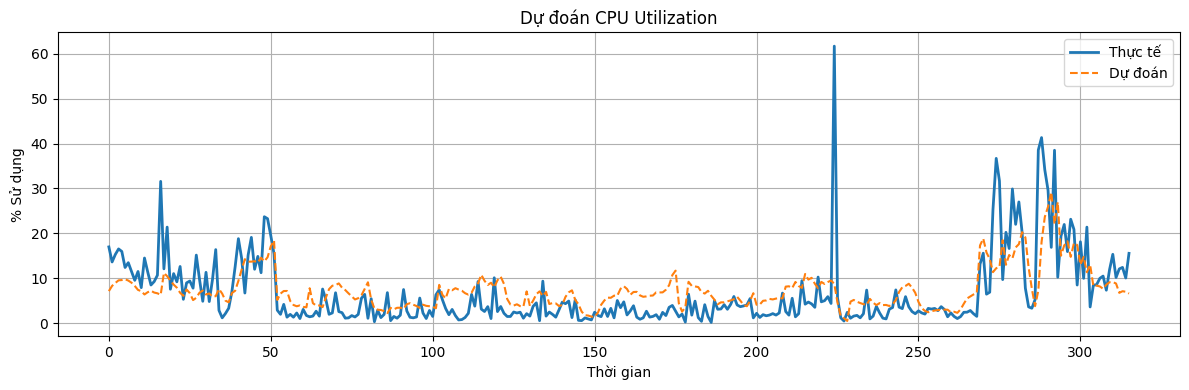

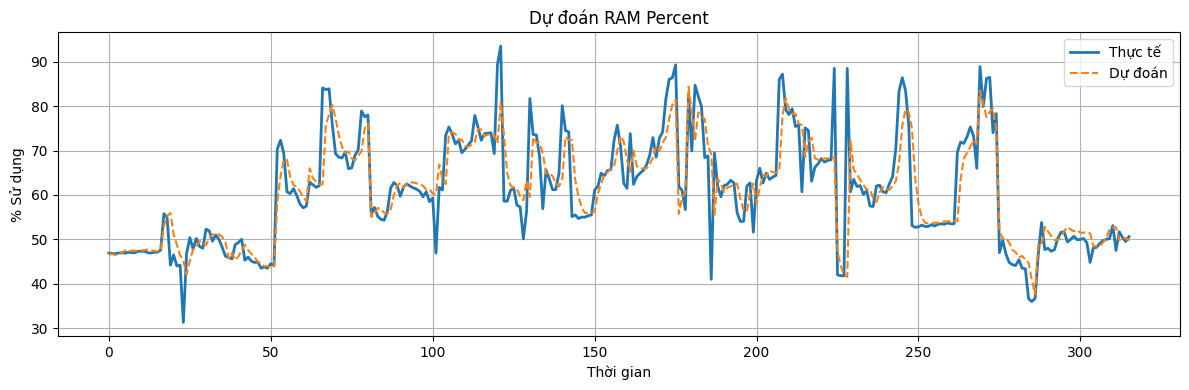

In [136]:
import matplotlib.pyplot as plt

def plot_prediction(true, pred, title):
    plt.figure(figsize=(12, 4))
    plt.plot(true, label='Thực tế', linewidth=2)
    plt.plot(pred, label='Dự đoán', linestyle='--')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('% Sử dụng')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_prediction(y_cpu_true[:-1], y_cpu_pred[:-1], 'Dự đoán CPU Utilization')
plot_prediction(y_ram_true[:-1], y_ram_pred[:-1], 'Dự đoán RAM Percent')

In [137]:
import tensorflow as tf

In [138]:
from google.colab import drive
drive.mount('/content/drive')

# Define the paths to save your models in your Drive
cpu_model_save_path = '/content/drive/MyDrive/ITAM_DATA/model_cpu.keras'  # Replace with your folder
ram_model_save_path = '/content/drive/MyDrive/ITAM_DATA/model_ram.keras'  # Replace with your folder

# Save the models
tf.keras.models.save_model(model_cpu, cpu_model_save_path)
tf.keras.models.save_model(model_ram, ram_model_save_path)

print(f"CPU model saved to: {cpu_model_save_path}")
print(f"RAM model saved to: {ram_model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU model saved to: /content/drive/MyDrive/ITAM_DATA/model_cpu.keras
RAM model saved to: /content/drive/MyDrive/ITAM_DATA/model_ram.keras


In [139]:
import joblib
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define save paths in your Drive
scaler_X_cpu_path = '/content/drive/MyDrive/ITAM_DATA/scaler_X.pkl'
scaler_y_cpu_path = '/content/drive/MyDrive/ITAM_DATA/scaler_y.pkl'
scaler_X_ram_path = '/content/drive/MyDrive/ITAM_DATA/scaler_X_ram.pkl'
scaler_y_ram_path = '/content/drive/MyDrive/ITAM_DATA/scaler_y_ram.pkl'

# Save the scalers
joblib.dump(scaler_X_cpu, scaler_X_cpu_path)
joblib.dump(scaler_y_cpu, scaler_y_cpu_path)
joblib.dump(scaler_X_ram, scaler_X_ram_path)
joblib.dump(scaler_y_ram, scaler_y_ram_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/ITAM_DATA/scaler_y_ram.pkl']

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import joblib

def predict_cpu_next_hour(model_path, scaler_X_path, scaler_y_path, input_df, n_steps=6, steps_ahead=6, plot = False):
    """
    Dự đoán hiệu suất CPU cho 1 giờ tiếp theo dựa trên dữ liệu 1 giờ trước đó.

    Parameters:
    - model_path: Đường dẫn đến file mô hình .keras
    - scaler_X_path: Đường dẫn đến file scaler_X.pkl
    - scaler_y_path: Đường dẫn đến file scaler_y.pkl
    - input_df: DataFrame chứa dữ liệu đầu vào (ít nhất 6 hàng cuối là dữ liệu 1 giờ trước)
    - n_steps: Số bước trong chuỗi đầu vào (mặc định 6, tương ứng 1 giờ với bước 10 phút)
    - steps_ahead: Số bước dự đoán (mặc định 6, tương ứng 1 giờ)

    Returns:
    - actual_cpu: Chuỗi CPU thực tế (nếu có)
    - predicted_cpu: Chuỗi CPU dự đoán
    """
    # Load mô hình và scaler
    model = tf.keras.models.load_model(model_path)
    scaler_X = joblib.load(scaler_X_path)
    scaler_y = joblib.load(scaler_y_path)

    # Các đặc trưng sử dụng
    features = ['cpu_utilization', 'cpu_processes', 'is_working_hour','ram_percent','hour','delta_processes','delta_cpu','is_after_boot','is_weekday']

    # Lấy chuỗi đầu vào (6 bước cuối cùng)
    last_sequence = input_df[features].values[-n_steps:]

    # Dự đoán
    preds = []
    seq = last_sequence.copy()

    for _ in range(steps_ahead):
        # Scale input
        seq_scaled = scaler_X.transform(seq).reshape(1, n_steps, len(features))

        # Dự đoán
        y_pred_scaled = model.predict(seq_scaled, verbose=0)

        # Inverse transform để lấy giá trị gốc
        y_pred = scaler_y.inverse_transform(y_pred_scaled)[0]
        preds.append(y_pred[0])  # Chỉ lấy CPU utilization

        # Cập nhật chuỗi đầu vào cho bước tiếp theo
        next_row = seq[-1].copy()
        next_row[0] = y_pred[0]  # Cập nhật CPU
        # next_row[1] = y_pred[1]  # Cập nhật RAM
        seq = np.vstack([seq[1:], next_row])

    # Chuẩn bị dữ liệu để vẽ biểu đồ
    actual_cpu = input_df['cpu_utilization'].values[-n_steps:]
    predicted_cpu = np.array(preds)
    if plot == True:
      # Vẽ biểu đồ
      plt.figure(figsize=(10, 6))

      # Vẽ dữ liệu thực tế
      time_steps_actual = range(n_steps)
      plt.plot(time_steps_actual, actual_cpu, label='Actual CPU Utilization', marker='o', color='blue')

      # Vẽ dữ liệu dự đoán
      time_steps_pred = range(n_steps, n_steps + steps_ahead)
      plt.plot(time_steps_pred, predicted_cpu, label='Predicted CPU Utilization', marker='x', color='red', linestyle='--')

      # Định dạng biểu đồ
      plt.xlabel('Time Steps (10 minutes each)')
      plt.ylabel('CPU Utilization (%)')
      plt.title('CPU Utilization: Actual vs Predicted')
      plt.xticks(range(n_steps + steps_ahead), [f'T-{n_steps-i}' if i < n_steps else f'T+{i-n_steps+1}' for i in range(n_steps + steps_ahead)])
      plt.grid(True)
      plt.legend()
      plt.show()

    return actual_cpu, predicted_cpu



In [145]:
# Ví dụ sử dụng hàm
# Đọc dữ liệu từ file CSV
df = pd.read_json('/content/drive/MyDrive/ITAM_DATA/test.json')


# Đảm bảo dữ liệu được sắp xếp theo thời gian
df['scantime'] = pd.to_datetime(df['scantime'])
df = df.sort_values('scantime')
#create empty df
new_df = pd.DataFrame(columns=['cpu_utilization', 'ram_percent'])
new_df['cpu_utilization'] = df['cpu'].apply(lambda x: x.get('utilization', np.nan))
new_df['cpu_processes'] = df['cpu'].apply(lambda x: x.get('processes', np.nan))
new_df['delta_cpu'] = new_df['cpu_utilization'].diff().fillna(0)
new_df['delta_ram'] = new_df['ram_percent'].diff().fillna(0)
new_df['delta_processes'] = new_df['cpu_processes'].diff().fillna(0).astype(int)
new_df['is_after_boot'] = 0
new_df.iloc[0, new_df.columns.get_loc('is_after_boot')] = 1
new_df['is_weekday'] = (df['scantime'].dt.weekday < 5).astype(int)

df['hour'] = df['scantime'].dt.hour
df['is_working_hour'] = df['hour'].between(8, 18).astype(int)
new_df['is_working_hour'] = df['is_working_hour']
new_df['ram_percent'] = df['ram'].apply(lambda x: x.get('percent', np.nan))
new_df['scantime'] = df['scantime']
new_df['hour'] = df['hour']
new_df['currentUser'] = df['currentUser']
new_df.head()




<ipython-input-145-51f5325bf49b>:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df['delta_ram'] = new_df['ram_percent'].diff().fillna(0)


,cpu_utilization,ram_percent,cpu_processes,delta_cpu,delta_ram,delta_processes,is_after_boot,is_weekday,is_working_hour,scantime,hour,currentUser
0,3.035,53.4,242,0.000,0,0,1,1,1,2025-04-18 14:24:28.259664,14,khang0032
1,1.410,53.7,245,-1.625,0,3,0,1,1,2025-04-18 14:34:31.970798,14,khang0032
2,2.270,53.5,241,0.860,0,-4,0,1,1,2025-04-18 14:44:35.678589,14,khang0032
3,1.485,53.5,241,-0.785,0,0,0,1,1,2025-04-18 14:54:39.613346,14,khang0032
4,1.015,69.6,260,-0.470,0,19,0,1,1,2025-04-18 15:04:43.395273,15,khang0032


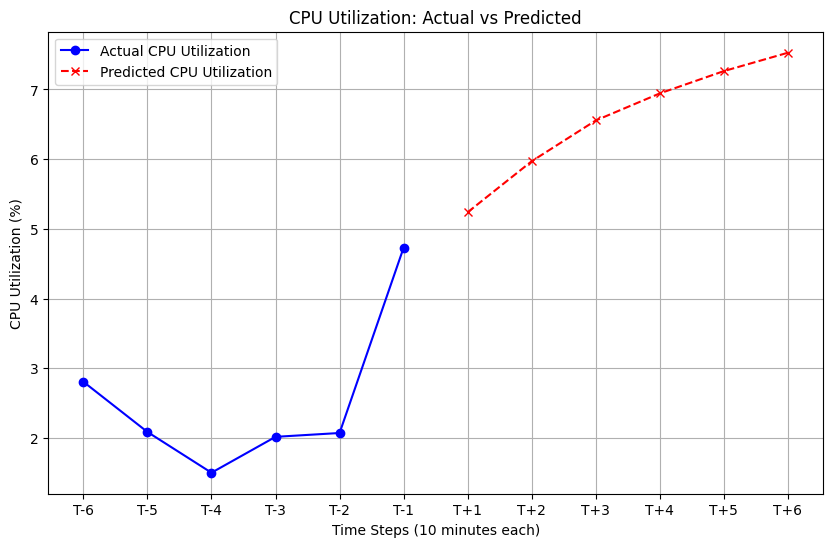

Actual CPU Utilization: [2.805 2.085 1.5   2.015 2.07  4.73 ]
Predicted CPU Utilization: [5.238112  5.969832  6.5548615 6.943349  7.263278  7.5269012]


In [146]:
# Gọi hàm dự đoán và vẽ biểu đồ

model_path = '/content/drive/MyDrive/ITAM_DATA/model_cpu.keras'
scaler_X_path = '/content/drive/MyDrive/ITAM_DATA/scaler_X.pkl'
scaler_y_path = '/content/drive/MyDrive/ITAM_DATA/scaler_y.pkl'

actual_cpu, predicted_cpu = predict_cpu_next_hour(model_path, scaler_X_path, scaler_y_path, new_df,plot = True)

print("Actual CPU Utilization:", actual_cpu)
print("Predicted CPU Utilization:", predicted_cpu)

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import joblib

def predict_ram_next_hour(model_path, scaler_X_path, scaler_y_path, input_df, n_steps=6, steps_ahead=6,plot = False):
    """
    Dự đoán hiệu suất RAM cho 1 giờ tiếp theo dựa trên dữ liệu 1 giờ trước đó.

    Parameters:
    - model_path: Đường dẫn đến file mô hình .keras
    - scaler_X_path: Đường dẫn đến file scaler_X.pkl
    - scaler_y_path: Đường dẫn đến file scaler_y.pkl
    - input_df: DataFrame chứa dữ liệu đầu vào (ít nhất 6 hàng cuối là dữ liệu 1 giờ trước)
    - n_steps: Số bước trong chuỗi đầu vào (mặc định 6, tương ứng 1 giờ với bước 10 phút)
    - steps_ahead: Số bước dự đoán (mặc định 6, tương ứng 1 giờ)

    Returns:
    - actual_ram: Chuỗi RAM thực tế (nếu có)
    - predicted_ram: Chuỗi RAM dự đoán
    """
    # Load mô hình và scaler
    model = tf.keras.models.load_model(model_path)
    scaler_X = joblib.load(scaler_X_path)
    scaler_y = joblib.load(scaler_y_path)

    # Các đặc trưng sử dụng
    features = ['ram_percent', 'is_working_hour','is_weekday','is_after_boot','delta_ram','delta_cpu','cpu_utilization','cpu_processes']

    # Kiểm tra xem tất cả các features có trong input_df không
    missing_features = [f for f in features if f not in input_df.columns]

    # Nếu có features bị thiếu, thêm chúng vào input_df với giá trị NaN
    for f in missing_features:
        input_df[f] = np.nan  # or any suitable default value

    # Lấy chuỗi đầu vào (6 bước cuối cùng)
    last_sequence = input_df[features].values[-n_steps:]

    # Dự đoán
    preds = []
    seq = last_sequence.copy()

    for _ in range(steps_ahead):
        # Scale input
        seq_scaled = scaler_X.transform(seq).reshape(1, n_steps, len(features))

        # Dự đoán
        y_pred_scaled = model.predict(seq_scaled, verbose=0)

        # Inverse transform để lấy giá trị gốc
        y_pred = scaler_y.inverse_transform(y_pred_scaled)[0]
        # The output of inverse_transform is a 1-element array. Get the first element.
        preds.append(y_pred[0])  # Lấy RAM percent

        # Cập nhật chuỗi đầu vào cho bước tiếp theo
        next_row = seq[-1].copy()
        next_row[0] = y_pred[0] # Update ram percent for the next sequence.
        # next_row[1] = y_pred[1]  # Cập nhật RAM
        seq = np.vstack([seq[1:], next_row])

    # Chuẩn bị dữ liệu để vẽ biểu đồ
    actual_ram = input_df['ram_percent'].values[-n_steps:]
    predicted_ram = np.array(preds)
    if plot is True:
      # Vẽ biểu đồ
      plt.figure(figsize=(10, 6))

      # Vẽ dữ liệu thực tế
      time_steps_actual = range(n_steps)
      plt.plot(time_steps_actual, actual_ram, label='Actual RAM Percent', marker='o', color='blue')

      # Vẽ dữ liệu dự đoán
      time_steps_pred = range(n_steps, n_steps + steps_ahead)
      plt.plot(time_steps_pred, predicted_ram, label='Predicted RAM Percent', marker='x', color='red', linestyle='--')

      # Định dạng biểu đồ
      plt.xlabel('Time Steps (10 minutes each)')
      plt.ylabel('RAM Percent (%)')
      plt.title('RAM Percent: Actual vs Predicted')
      plt.xticks(range(n_steps + steps_ahead), [f'T-{n_steps - i}' if i < n_steps else f'T+{i - n_steps + 1}' for i in range(n_steps + steps_ahead)])
      plt.grid(True)
      plt.legend()
      plt.show()

    return actual_ram, predicted_ram

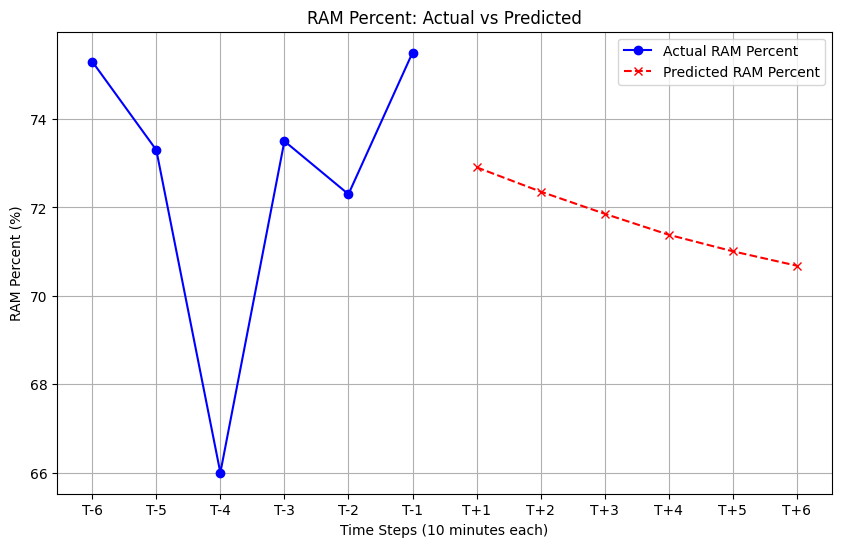

Actual RAM Percent: [75.3 73.3 66.  73.5 72.3 75.5]
Predicted RAM Percent: [72.908394 72.358765 71.85768  71.38225  71.00896  70.68254 ]


In [148]:
# Gọi hàm dự đoán và vẽ biểu đồ
model_path_ram = '/content/drive/MyDrive/ITAM_DATA/model_ram.keras'
scaler_X_path_ram = '/content/drive/MyDrive/ITAM_DATA/scaler_X_ram.pkl' # Changed to scaler_X_ram
scaler_y_path_ram = '/content/drive/MyDrive/ITAM_DATA/scaler_y_ram.pkl' # Changed to scaler_y_ram
actual_ram, predicted_ram = predict_ram_next_hour(model_path_ram, scaler_X_path_ram, scaler_y_path_ram, new_df,plot = True)

print("Actual RAM Percent:", actual_ram)
print("Predicted RAM Percent:", predicted_ram)

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import joblib
import math


# ... (your existing predict_cpu_next_hour and predict_ram_next_hour functions) ...


def evaluate_model_accuracy(actual_values, predicted_values):
    """
    Đánh giá độ chính xác của mô hình bằng cách sử dụng RMSE và MAE.

    Parameters:
    - actual_values: Mảng NumPy chứa các giá trị thực tế.
    - predicted_values: Mảng NumPy chứa các giá trị dự đoán.

    Returns:
    - rmse: Giá trị RMSE.
    - mae: Giá trị MAE.
    """
    rmse = math.sqrt(mean_squared_error(actual_values, predicted_values))
    mae = mean_absolute_error(actual_values, predicted_values)
    return rmse, mae


# Predict CPU
actual_cpu, predicted_cpu = predict_cpu_next_hour(model_path, scaler_X_path, scaler_y_path, new_df)

# Evaluate CPU prediction accuracy
rmse_cpu, mae_cpu = evaluate_model_accuracy(actual_cpu, predicted_cpu)
print(f"CPU Prediction - RMSE: {rmse_cpu}, MAE: {mae_cpu}")

# Predict RAM
actual_ram, predicted_ram = predict_ram_next_hour(model_path_ram, scaler_X_path_ram, scaler_y_path_ram, new_df,plot = False)

# Evaluate RAM prediction accuracy
rmse_ram, mae_ram = evaluate_model_accuracy(actual_ram, predicted_ram)
print(f"RAM Prediction - RMSE: {rmse_ram}, MAE: {mae_ram}")

CPU Prediction - RMSE: 4.19612905173186, MAE: 4.048555599848429
RAM Prediction - RMSE: 3.42241903205451, MAE: 2.9027961730957017
